In [70]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [71]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [72]:
df = df.resample('D').ffill()


<AxesSubplot:xlabel='Date'>

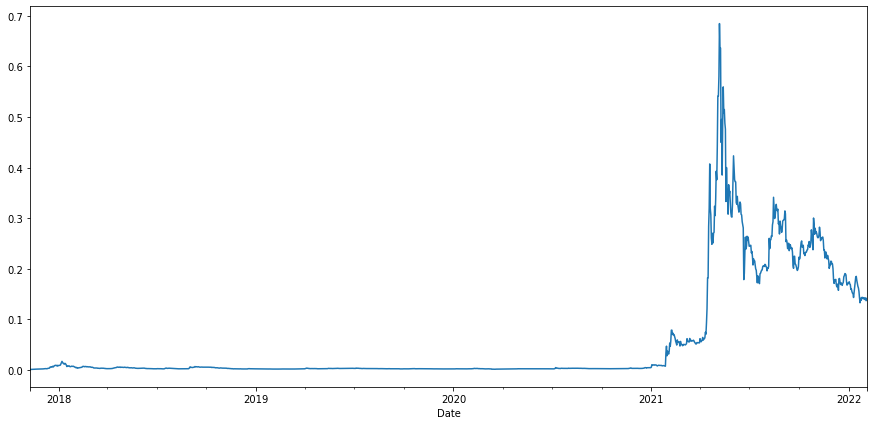

In [73]:
df.Close.plot(figsize=(15, 7))

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Freq: D
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   Open                         1549 non-null   float64       
 2   High                         1549 non-null   float64       
 3   Low                          1549 non-null   float64       
 4   Close                        1549 non-null   float64       
 5   Adj Close                    1549 non-null   float64       
 6   Volume                       1549 non-null   int64         
 7   twitter_followers            1549 non-null   float64       
 8   reddit_average_posts_48h     1549 non-null   float64       
 9   reddit_average_comments_48h  1549 non-null   float64       
 10  reddit_subscribers           1549 non-null   float64       
 11  reddit_accounts_a

In [75]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
window1 = 7
window2 = 14
window3 = 30
window4 = 3
window5 = 21
window6 = 60
'''
df_rolled_7d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_14d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
df_rolled_3d = df[lag_features].rolling(window=window4, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_14d = df_rolled_14d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_14d = df_rolled_14d.std().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)
'''

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df[feature].shift(window1)
    df[f"{feature}_mean_lag{window2}"] = df[feature].shift(window2)
    df[f"{feature}_mean_lag{window3}"] = df[feature].shift(window3)
    df[f"{feature}_mean_lag{window4}"] = df[feature].shift(window4)
    df[f"{feature}_mean_lag{window5}"] = df[feature].shift(window5)
    df[f"{feature}_mean_lag{window6}"] = df[feature].shift(window6)

    '''
    df[f"{feature}_mean_lag{window1}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_14d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window4}"] = df_mean_3d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_14d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window4}"] = df_std_3d[feature]
    '''
df.fillna(df.mean(), inplace=True)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,dogecoin_monthly_mean_lag30,dogecoin_monthly_mean_lag3,dogecoin_monthly_mean_lag21,dogecoin_monthly_mean_lag60,dogecoin_mean_lag7,dogecoin_mean_lag14,dogecoin_mean_lag30,dogecoin_mean_lag3,dogecoin_mean_lag21,dogecoin_mean_lag60
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,4.707702,4.72445,4.717277,4.695769,1.896946,1.895557,1.890658,1.896604,1.894476,1.89317
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,4.707702,4.72445,4.717277,4.695769,1.896946,1.895557,1.890658,1.896604,1.894476,1.89317
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,4.707702,4.72445,4.717277,4.695769,1.896946,1.895557,1.890658,1.896604,1.894476,1.89317
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,4.707702,1.00000,4.717277,4.695769,1.896946,1.895557,1.890658,0.570000,1.894476,1.89317
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,4.707702,1.00000,4.717277,4.695769,1.896946,1.895557,1.890658,0.240000,1.894476,1.89317


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Columns: 138 entries, Date to dogecoin_mean_lag60
dtypes: datetime64[ns](1), float64(135), int64(2)
memory usage: 1.6 MB


In [77]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7698.448, Time=8.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6341.341, Time=5.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7631.384, Time=5.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6851.969, Time=5.95 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2356.134, Time=4.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7666.991, Time=7.61 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5416.854, Time=6.57 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-6697.263, Time=8.32 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7669.700, Time=8.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7634.230, Time=6.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7674.360, Time=7.88 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7666.188, Time=7.88 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7693.838, Time=8.45 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7700.676, Time=7.45 sec
 ARIMA(1,0,2)(0,0,0)

<AxesSubplot:xlabel='Date'>

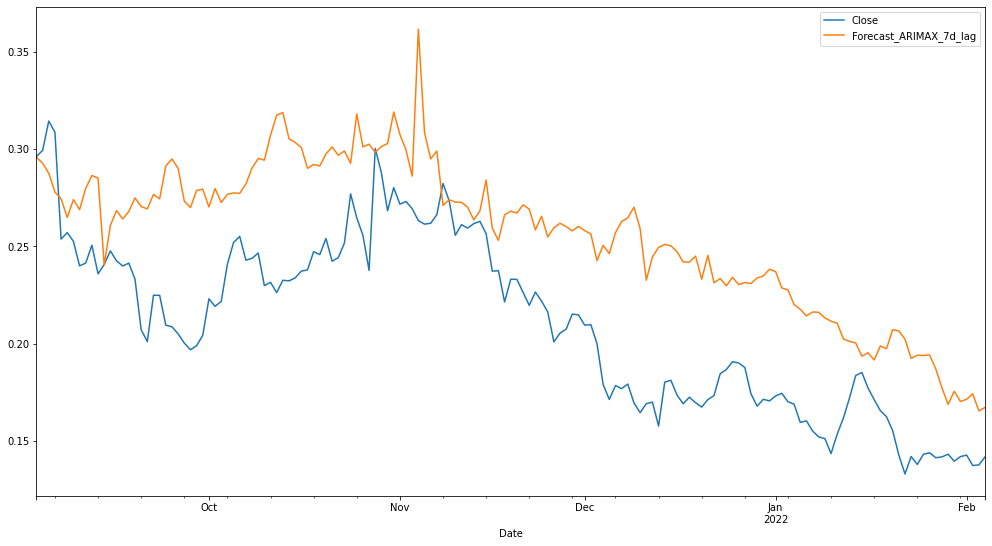

In [78]:
from pmdarima import auto_arima

#Pokusavam predikciju nad lagom od 7 dana
exog_7_days = []
for feature in lag_features:
    exog_7_days.append(f"{feature}_mean_lag{window1}")
    #exog_7_days.append(f"{feature}_std_lag{window1}")

model = auto_arima(train.Close, exogenous=train[exog_7_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_7_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_7_days])
test["Forecast_ARIMAX_7d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_7d_lag"]].plot(figsize=(17, 9))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7070.210, Time=7.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5980.249, Time=5.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7156.388, Time=5.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6572.978, Time=5.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2717.226, Time=4.81 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7177.702, Time=6.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7175.915, Time=7.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7175.735, Time=6.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7175.752, Time=6.28 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7173.577, Time=7.83 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7179.736, Time=5.77 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7158.407, Time=5.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-7177.956, Time=7.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7177.771, Time=6.15 sec
 ARIMA(1,0,1)(0,0,0)

<AxesSubplot:xlabel='Date'>

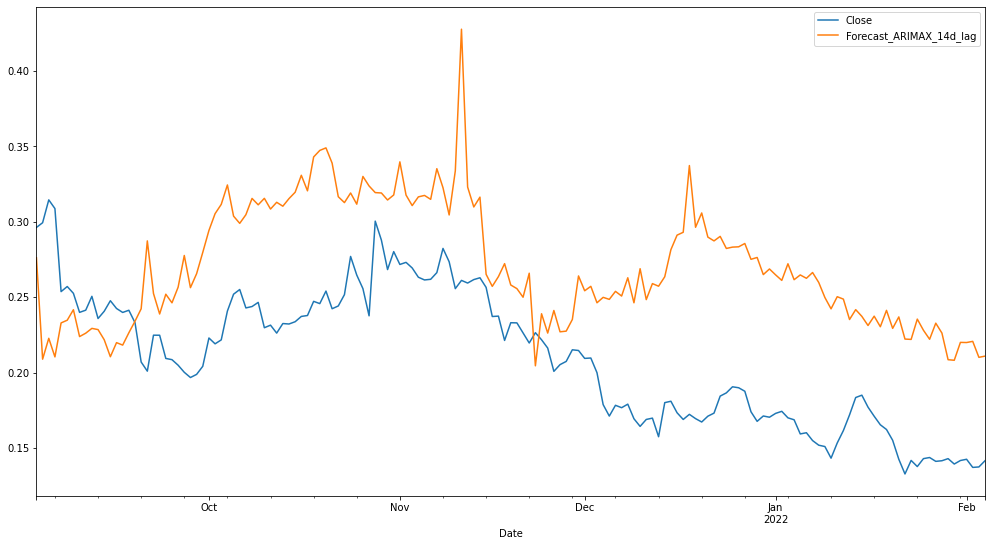

In [79]:
#Pokusavam predikciju nad lagom od 14 dana
exog_14_days = []
for feature in lag_features:
    exog_14_days.append(f"{feature}_mean_lag{window2}")
    #exog_14_days.append(f"{feature}_std_lag{window2}")

model = auto_arima(train.Close, exogenous=train[exog_14_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_14_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_14_days])
test["Forecast_ARIMAX_14d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_14d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7190.746, Time=7.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5385.848, Time=5.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7183.981, Time=5.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5823.931, Time=5.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3311.619, Time=4.85 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7198.983, Time=7.54 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6509.927, Time=7.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7199.075, Time=6.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7198.297, Time=6.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7200.320, Time=6.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7198.317, Time=7.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7195.959, Time=7.86 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7202.342, Time=5.85 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7186.005, Time=5.04 sec
 ARIMA(3,0,0)(0,0,0)

<AxesSubplot:xlabel='Date'>

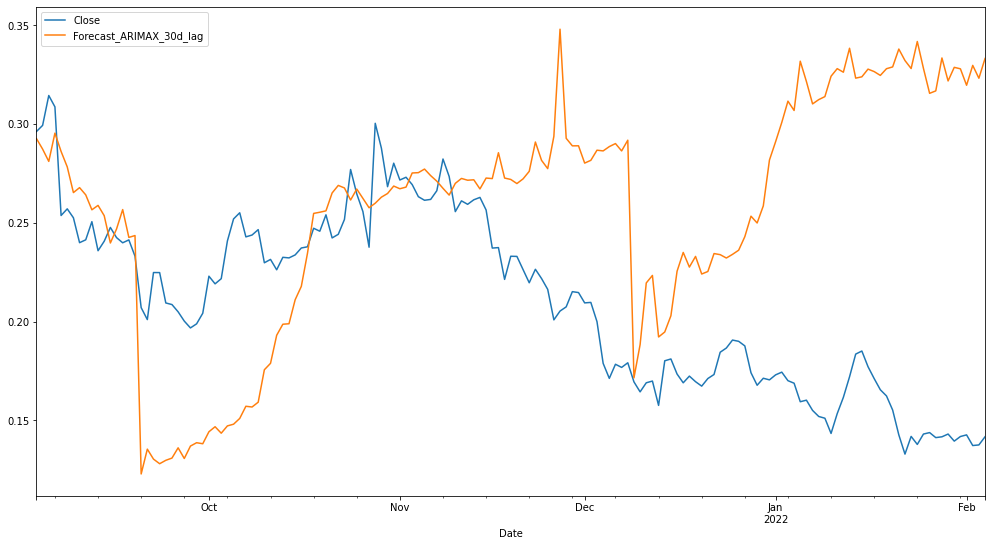

In [80]:
#Pokusavam predikciju nad lagom od 30 dana
exog_30_days = []
for feature in lag_features:
    exog_30_days.append(f"{feature}_mean_lag{window3}")
    #exog_30_days.append(f"{feature}_std_lag{window3}")

model = auto_arima(train.Close, exogenous=train[exog_30_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_30_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_30_days])
test["Forecast_ARIMAX_30d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_30d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7950.587, Time=7.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7174.737, Time=5.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7612.746, Time=5.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7306.497, Time=6.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1522.733, Time=4.77 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7935.940, Time=7.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6940.077, Time=6.66 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7951.814, Time=8.26 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7897.699, Time=7.82 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-6832.042, Time=8.50 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-8026.016, Time=8.59 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-8006.724, Time=8.06 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-8047.591, Time=8.87 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-8021.149, Time=10.89 sec
 ARIMA(4,0,4)(0,0,0

<AxesSubplot:xlabel='Date'>

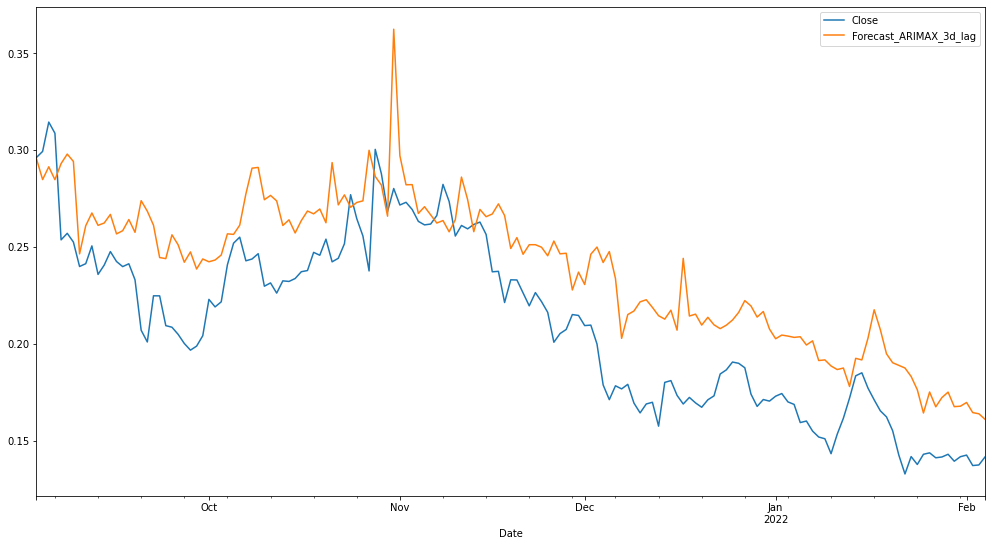

In [81]:
#Pokusavam predikciju nad lagom od 3 dana
exog_3_days = []
for feature in lag_features:
    exog_3_days.append(f"{feature}_mean_lag{window4}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_3_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_3_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_3_days])
test["Forecast_ARIMAX_3d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_3d_lag"]].plot(figsize=(17, 9))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6873.312, Time=7.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5770.426, Time=5.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6850.472, Time=5.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6348.417, Time=5.96 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2927.041, Time=4.85 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-6875.429, Time=7.51 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6470.445, Time=7.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6877.431, Time=6.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6874.939, Time=6.54 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6876.477, Time=6.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6879.488, Time=5.87 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6350.415, Time=5.60 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6852.488, Time=5.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6877.008, Time=6.17 sec
 ARIMA(1,0,2)(0,0,0)

<AxesSubplot:xlabel='Date'>

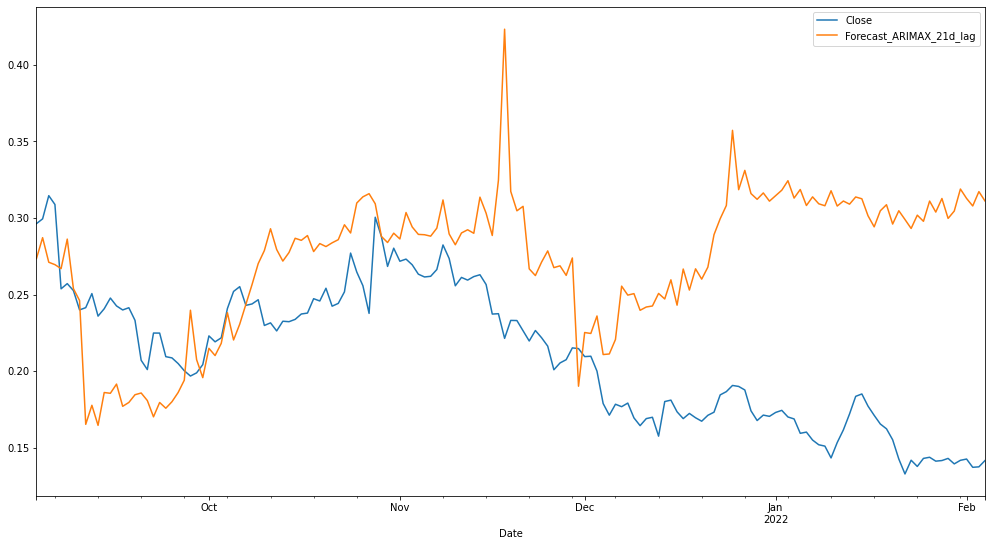

In [82]:
#Pokusavam predikciju nad lagom od 21 dana
exog_21_days = []
for feature in lag_features:
    exog_21_days.append(f"{feature}_mean_lag{window5}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_21_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_21_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_21_days])
test["Forecast_ARIMAX_21d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_21d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8338.488, Time=8.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8266.619, Time=5.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8293.146, Time=5.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8284.711, Time=6.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=424.151, Time=5.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8355.171, Time=7.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8343.425, Time=7.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8315.169, Time=7.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8346.833, Time=9.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8336.433, Time=8.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8356.695, Time=7.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8352.561, Time=7.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8357.625, Time=8.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8359.440, Time=7.66 sec
 ARIMA(4,1,0)(0,0,0)[

<AxesSubplot:xlabel='Date'>

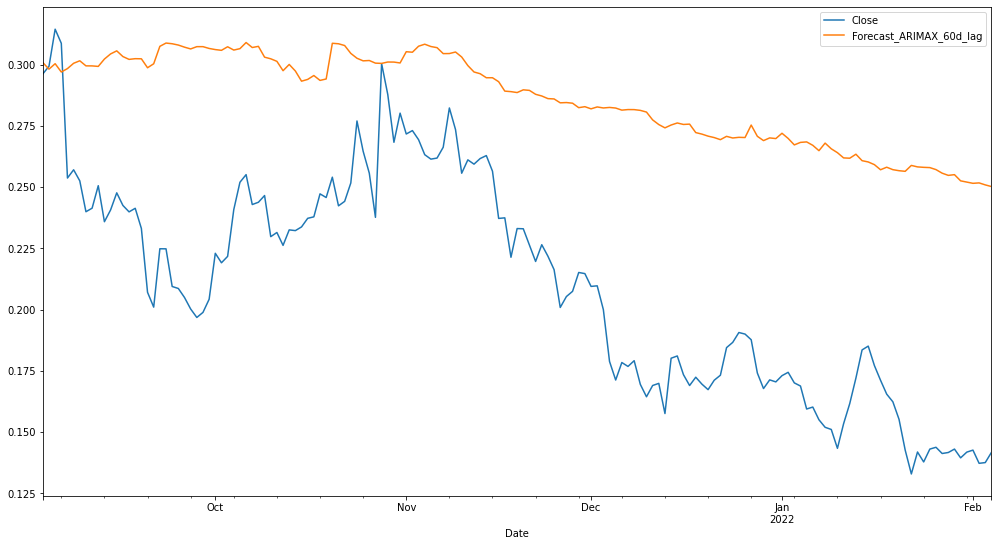

In [83]:
#Pokusavam predikciju nad lagom od 60 dana
exog_60_days = []
for feature in lag_features:
    exog_60_days.append(f"{feature}_mean_lag{window6}")
    #exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_60_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_60_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_60_days])
test["Forecast_ARIMAX_60d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_60d_lag"]].plot(figsize=(17, 9))

In [84]:
def mape(actual,pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

d3_mape = mape(test.Close, test.Forecast_ARIMAX_3d_lag)
d7_mape = mape(test.Close, test.Forecast_ARIMAX_7d_lag)
d14_mape = mape(test.Close, test.Forecast_ARIMAX_14d_lag)
d30_mape = mape(test.Close, test.Forecast_ARIMAX_30d_lag)
print(f"MAPE 3D: {d3_mape}")
print(f"MAPE 7D: {d7_mape}")
print(f"MAPE 14D: {d14_mape}")
print(f"MAPE 30D: {d30_mape}")

MAPE 3D: 16.1517856779555
MAPE 7D: 24.44507340679015
MAPE 14D: 35.448045330746446
MAPE 30D: 42.270252342861895


In [85]:
exog_all = df.columns[24:]
print(exog_all)


Index(['High_mean_lag7', 'High_mean_lag14', 'High_mean_lag30',
       'High_mean_lag3', 'High_mean_lag21', 'High_mean_lag60', 'Low_mean_lag7',
       'Low_mean_lag14', 'Low_mean_lag30', 'Low_mean_lag3',
       ...
       'dogecoin_monthly_mean_lag30', 'dogecoin_monthly_mean_lag3',
       'dogecoin_monthly_mean_lag21', 'dogecoin_monthly_mean_lag60',
       'dogecoin_mean_lag7', 'dogecoin_mean_lag14', 'dogecoin_mean_lag30',
       'dogecoin_mean_lag3', 'dogecoin_mean_lag21', 'dogecoin_mean_lag60'],
      dtype='object', length=114)


In [88]:
df.drop(exog_all, 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   Open                         1549 non-null   float64       
 2   High                         1549 non-null   float64       
 3   Low                          1549 non-null   float64       
 4   Close                        1549 non-null   float64       
 5   Adj Close                    1549 non-null   float64       
 6   Volume                       1549 non-null   int64         
 7   twitter_followers            1549 non-null   float64       
 8   reddit_average_posts_48h     1549 non-null   float64       
 9   reddit_average_comments_48h  1549 non-null   float64       
 10  reddit_subscribers           1549 non-null   float64       
 11  reddit_accounts_active_48